In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("JRB.csv", low_memory=False)  # force to str
# df[df['station'] == 'JRB'].shape[0] == df.shape[0]

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# Load the dataset
# Replace 'your_dataset.csv' with your actual data file
df = pd.read_csv('JRB.csv', low_memory=False)

# Step 1: Ensure 'valid' column is datetime and sort the DataFrame
df['valid'] = pd.to_datetime(df['valid'])
df = df.sort_values(by=['station', 'valid']).reset_index(drop=True)

In [4]:
df.head()

,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,...,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar,snowdepth
0,JRB,2016-07-21 08:15:00,73.40,66.20,78.19,240.00,5.00,0.00,30.17,M,...,M,M,M,M,M,M,M,73.40,KJRB 211215Z 24005KT 10SM CLR 23/19 A3017 RMK AO1,M
1,JRB,2016-07-21 08:35:00,73.40,66.20,78.19,240.00,5.00,0.00,30.17,M,...,M,M,M,M,M,M,M,73.40,KJRB 211235Z 24005KT 10SM CLR 23/19 A3017 RMK AO1,M
2,JRB,2016-07-21 08:55:00,75.20,66.20,73.61,240.00,6.00,0.00,30.17,M,...,M,M,M,M,M,M,M,75.20,KJRB 211255Z 24006KT 10SM CLR 24/19 A3017 RMK AO1,M
3,JRB,2016-07-21 09:15:00,75.20,66.20,73.61,240.00,5.00,0.00,30.17,M,...,M,M,M,M,M,M,M,75.20,KJRB 211315Z 24005KT 10SM CLR 24/19 A3017 RMK AO1,M
4,JRB,2016-07-21 09:35:00,78.80,66.20,65.33,240.00,5.00,0.00,30.16,M,...,M,M,M,M,M,M,M,80.82,KJRB 211335Z 24005KT 10SM CLR 26/19 A3016 RMK AO1,M


In [5]:
# Step 2: Replace placeholders with np.nan in continuous columns
continuous_cols = ['tmpf', 'dwpf', 'relh', 'feel', 'drct', 'sknt', 'gust',
                   'peak_wind_gust', 'peak_wind_drct', 'alti', 'mslp', 'vsby',
                   'p01i', 'ice_accretion_1hr', 'ice_accretion_3hr', 'ice_accretion_6hr',
                   'skyl1', 'skyl2', 'skyl3', 'skyl4', 'snowdepth', 'peak_wind_time']

# List of placeholders to replace
placeholders = ['M', 'T', '', 'NaN', 'NULL', 'None']

# Replace placeholders with np.nan
df[continuous_cols] = df[continuous_cols].replace(placeholders, np.nan).astype(str)

# Convert continuous columns to numeric, coercing errors to np.nan
for col in continuous_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

/tmp/ipykernel_1698756/2860399940.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[continuous_cols] = df[continuous_cols].replace(placeholders, np.nan).astype(str)


In [6]:
print("Missing values in continuous columns before processing:")
print(df[continuous_cols].isnull().sum())

Missing values in continuous columns before processing:
tmpf                   6865
dwpf                   7015
relh                   7112
feel                   7125
drct                  25052
sknt                   5024
gust                 101714
peak_wind_gust       108345
peak_wind_drct       108345
alti                  12732
mslp                  37235
vsby                   9941
p01i                   7730
ice_accretion_1hr    114664
ice_accretion_3hr    114664
ice_accretion_6hr    114664
skyl1                 54223
skyl2                 93650
skyl3                107296
skyl4                114664
snowdepth            114664
peak_wind_time       114664
dtype: int64


In [7]:
# Step 3: Handle missing values in continuous variables
# Apply linear interpolation within each station group using transform
df[continuous_cols] = df.groupby('station')[continuous_cols].transform(
    lambda group: group.interpolate(method='linear')
)

# Handle any remaining missing values with forward and backward fill using transform
df[continuous_cols] = df.groupby('station')[continuous_cols].transform(
    lambda group: group.ffill().bfill()
)

# all of these columns have all nans
bad_columns = bad_columns = [col for col in df.columns if df[col].isnull().sum() == df.shape[0]]
# for JRB, this is ['ice_accretion_1hr', 'ice_accretion_3hr', 'ice_accretion_6hr', 'skyl4', 'snowdepth', 'peak_wind_time']
df.drop(columns=bad_columns, inplace=True)
continuous_cols = list(set(continuous_cols) - set(bad_columns))


# Verify missing values are filled
print("Missing values in continuous columns after processing:")
print(df[continuous_cols].isnull().sum())

Missing values in continuous columns after processing:
feel              0
vsby              0
drct              0
mslp              0
sknt              0
skyl2             0
p01i              0
dwpf              0
relh              0
tmpf              0
peak_wind_gust    0
skyl3             0
peak_wind_drct    0
skyl1             0
alti              0
gust              0
dtype: int64


In [8]:
# Step 4: Encode categorical variables
# Categorical columns
categorical_cols = ['station', 'skyc1', 'skyc2', 'skyc3', 'skyc4', 'wxcodes']

# Fill missing values in categorical columns with a placeholder
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

print(df[categorical_cols].head())

# Apply label encoding to categorical columns
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le  # Save the encoder if needed later

print(df[categorical_cols].head())

  station skyc1 skyc2 skyc3 skyc4 wxcodes
0     JRB   CLR     M     M     M       M
1     JRB   CLR     M     M     M       M
2     JRB   CLR     M     M     M       M
3     JRB   CLR     M     M     M       M
4     JRB   CLR     M     M     M       M
   station  skyc1  skyc2  skyc3  skyc4  wxcodes
0        0      1      2      1      0       26
1        0      1      2      1      0       26
2        0      1      2      1      0       26
3        0      1      2      1      0       26
4        0      1      2      1      0       26


In [9]:
set(df.columns) - set(df[continuous_cols].columns) - set(df[categorical_cols].columns)

{'metar', 'valid'}

In [10]:
# Step 5: Feature scaling
# List of all features (excluding 'valid' and 'metar')
feature_cols = continuous_cols + categorical_cols
print(df[feature_cols].shape)

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the features
df[feature_cols] = scaler.fit_transform(df[feature_cols])


(114664, 22)


In [11]:
# Step 6: Prepare sequences for LSTM input
# Assuming we are predicting 'tmpf' (temperature) as the target variable
# and using previous 24 time steps/8 hours (n_steps_in) to predict the next time step/20 minutes from now (n_steps_out)
# create sliding window sequences X: (114640, 24, features), y: (114640, 1)

n_steps_in = 24  # Number of past time steps
n_steps_out = 1  # Number of future time steps to predict

# We'll create sequences for each station separately
def create_sequences(data, n_steps_in, n_steps_out, target_col):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:(i + n_steps_in), :])
        y.append(data[(i + n_steps_in):(i + n_steps_in + n_steps_out), target_col])
    return np.array(X), np.array(y)

# Prepare data for each station
X_list = []
y_list = []
stations = df['station'].unique()

for station in stations:
    station_data = df[df['station'] == station]
    station_data = station_data.reset_index(drop=True)
    data_values = station_data[feature_cols].values
    target_col_index = feature_cols.index('tmpf')  # Index of target variable in features

    X_station, y_station = create_sequences(data_values, n_steps_in, n_steps_out, target_col_index)
    X_list.append(X_station)
    y_list.append(y_station)


# Concatenate data from all stations
X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

print(X.shape)
print(y.shape)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

(114640, 24, 22)
(114640, 1)


In [12]:
# Step 7: Split the data into training and testing sets
# Since it's time-series data, we'll use the first 80% for training and the rest for testing
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Now the data is ready for training the LSTM model

# Define a PyTorch Dataset
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [13]:
# Create DataLoaders
batch_size = 32
train_dataset = WeatherDataset(X_train, y_train)
test_dataset = WeatherDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 8: Define and Train an LSTM Model Using PyTorch

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # batch_first=True: input and output tensors are of shape (batch, seq, feature)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # Decode the hidden state of the last time step
        out = out[:, -1, :]  # Take the output from the last time step
        out = self.fc(out)
        return out

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device is {device}')

input_size = X.shape[2]  # Number of features
print(f'inputsize is {input_size}')
hidden_size = 50
num_layers = 1
output_size = n_steps_out  # Number of outputs

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device is cuda
inputsize is 22


Epoch [1/100], Train Loss: 0.0360, Val Loss: 0.0074
Epoch [2/100], Train Loss: 0.0233, Val Loss: 0.0066
Epoch [3/100], Train Loss: 0.0281, Val Loss: 0.0066
Epoch [4/100], Train Loss: 0.0254, Val Loss: 0.0068
Epoch [5/100], Train Loss: 0.0263, Val Loss: 0.0066
Epoch [6/100], Train Loss: 0.0251, Val Loss: 0.0071
Epoch [7/100], Train Loss: 0.0205, Val Loss: 0.0066
Epoch [8/100], Train Loss: 0.0160, Val Loss: 0.0069
Epoch [9/100], Train Loss: 0.0136, Val Loss: 0.0070
Epoch [10/100], Train Loss: 0.0207, Val Loss: 0.0063
Epoch [11/100], Train Loss: 0.0160, Val Loss: 0.0068
Epoch [12/100], Train Loss: 0.0157, Val Loss: 0.0066
Epoch [13/100], Train Loss: 0.0126, Val Loss: 0.0064
Epoch [14/100], Train Loss: 0.0126, Val Loss: 0.0064
Epoch [15/100], Train Loss: 0.0127, Val Loss: 0.0063
Epoch [16/100], Train Loss: 0.0124, Val Loss: 0.0060
Epoch [17/100], Train Loss: 0.0122, Val Loss: 0.0063
Epoch [18/100], Train Loss: 0.0123, Val Loss: 0.0060
Epoch [19/100], Train Loss: 0.0118, Val Loss: 0.0060
Ep

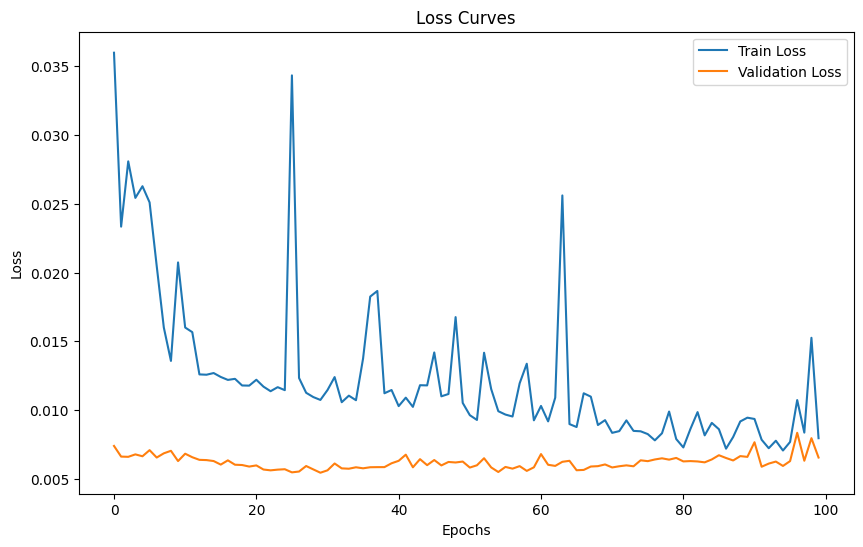

In [15]:
# Import additional libraries for visualization
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# Initialize lists for logging losses
train_losses = []
val_losses = []

# Step 9: Training the model with logging
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Optional: Validation loss (calculated on test_loader)
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plotting loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()


In [ ]:

# Step 10: Evaluate the model with scatter plots and metrics
model.eval()
with torch.no_grad():
    predictions = []
    actuals = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())
        actuals.append(targets.cpu().numpy())
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    # Calculate additional metrics
    r2 = r2_score(actuals, predictions)
    rmse = mean_squared_error(actuals, predictions, squared=False)

    print(f"Test R²: {r2:.4f}")
    print(f"Test RMSE: {rmse:.4f}")

# Scatter plot of predicted vs actual
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.6)
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', label='Ideal Fit')  # Ideal line
plt.xlabel("Actual Temperatures")
plt.ylabel("Predicted Temperatures")
plt.title("Predicted vs. Actual Values")
plt.legend()
plt.show()

# Time-series plot of predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(actuals[:100], label="Actual")
plt.plot(predictions[:100], label="Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Temperature")
plt.title("Temperature Prediction Over Time")
plt.legend()
plt.show()
